# Analyse ROMY Events - Montenegro

In [97]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np

from obspy.clients.fdsn import Client


In [98]:
# from functions.makeplot_spectra_comparison_fill import __makeplot_spectra_comparison_fill
# from functions.compute_backazimuth import __compute_backazimuth
# from functions.makeplot_waveform_comparison_cc import __makeplot_waveform_comparison_cc
# from functions.makeplot_comparison_ccf import __makeplot_comparison_ccf
# from functions.get_event_info import __get_event_info
# from functions.compute_cross_wavelet_transform import __compute_cross_wavelet_transform
# from functions.compute_cwt import __compute_cwt

In [99]:
# if os.uname().nodename == 'lighthouse':
#     root_path = '/home/andbro/'
#     data_path = '/home/andbro/kilauea-data/'
#     archive_path = '/home/andbro/freenas/'
# elif os.uname().nodename == 'kilauea':
#     root_path = '/home/brotzer/'
#     data_path = '/import/kilauea-data/'
#     archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [112]:
config = {}

# path to data
config['path_to_data'] = "./"

config['path_to_figs'] = "./"

# Event
config['tbeg'] = obs.UTCDateTime("2024-03-14 03:06")
config['tend'] = obs.UTCDateTime("2024-03-14 03:36")

config['event_name'] = "Montenegro"

config['filename'] = f"ROMY_{config['event_name']}_{str(config['tbeg'].date).replace('-','')}_6C.mseed"

config['Client'] = Client("USGS")

# ROMY coordinates
config['sta_lon'] = 11.275501
config['sta_lat'] = 48.162941


## Load Data

In [101]:
def __get_event_info(config, min_mag=5.0):

    from obspy.geodetics.base import gps2dist_azimuth

    event = config['Client'].get_events(starttime=config['tbeg']-60, endtime=config['tend'], minmagnitude=min_mag)

    if len(event) > 1:
        print("-> more than one event\n")
        print(event)
        num = int(input("Select Event number: "))
    else:
        num = 0

    config['event'] = event[num]

    ## Eventtime
    config['eventtime'] = event[0].origins[0].time

    print(event[0])

    dist, az, baz = gps2dist_azimuth(event[0].origins[0].latitude, event[0].origins[0].longitude,
                                     config['sta_lat'], config['sta_lon'],
                                     )
    # to km
    dist /= 1000

    print("Distance ", dist, "km", "Azimuth ", az, "Backazimuth ", baz)

    return config, dist, baz, az

In [104]:
config, dist, baz, az = __get_event_info(config)

Event:	2024-03-14T03:06:46.795000Z | +42.994,  +18.680 | 5.4  mww | manual

	            resource_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/fdsnws/event/1/query?eventid=us6000mirj&format=quakeml")
	             event_type: 'earthquake'
	          creation_info: CreationInfo(agency_id='us', creation_time=UTCDateTime(2024, 3, 15, 15, 21, 4, 101000))
	    preferred_origin_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/product/origin/us6000mirj/us/1710386705040/product.xml")
	 preferred_magnitude_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/product/origin/us6000mirj/us/1710386705040/product.xml#magnitude")
	                   ---------
	     event_descriptions: 1 Elements
	                origins: 1 Elements
	             magnitudes: 1 Elements
Distance  814.170164034937 km Azimuth  317.4325644063705 Backazimuth  132.135491589739


/tmp/ipykernel_303243/3269531116.py:21: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  dist, az, baz = gps2dist_azimuth(event[0].origins[0].latitude, event[0].origins[0].longitude,


In [105]:
st0 = obs.read(config['path_to_data']+config['filename'])

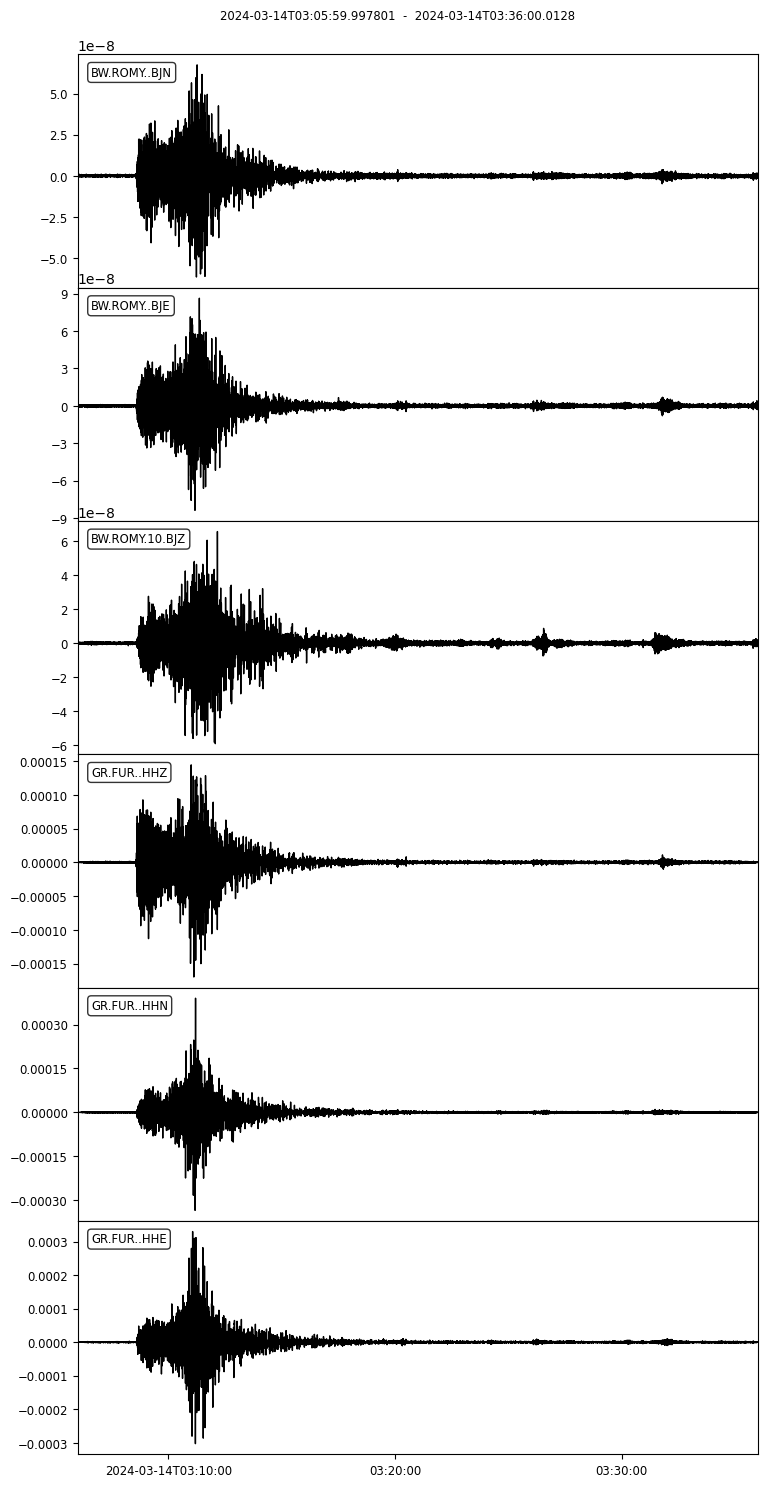

In [106]:
st0.plot(equal_scale=False);

In [107]:
dt1, dt2 = 120, 1000
st0 = st0.trim(config['tbeg']+dt1, config['tend']-dt2)


In [108]:

fmin, fmax = 0.01, 0.2

rot1 = st0.select(station="ROMY", channel="*J*").copy()
acc1 = st0.select(station="FUR*", channel="*H*").copy()

rot1 = rot1.detrend("linear").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True);
acc1 = acc1.detrend("linear").taper(0.01).filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True);


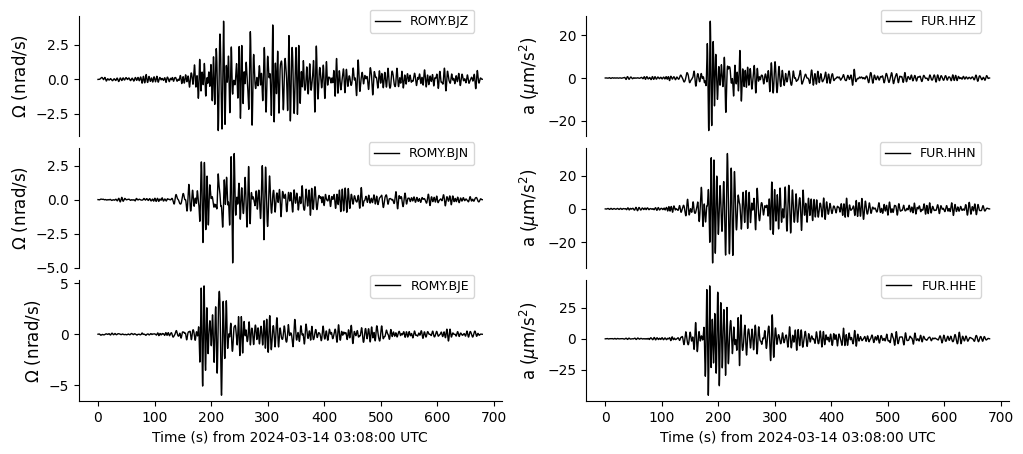

In [113]:
def __makeplot_waveforms(acc, rot):

    import matplotlib.pyplot as plt

    from matplotlib.gridspec import GridSpec
    from numpy import arange, mean, nan, nanmax
    from pandas import DataFrame
    from functions.get_octave_bands import __get_octave_bands
    from scipy.signal import coherence

    rot_scale, rot_unit = 1e9, "nrad/s"
    acc_scale, acc_unit = 1e6, "$\mu$m/s$^2$"


    Nrow, Ncol = 3, 2
    font = 12
    lw = 1

    fig = plt.figure(figsize=(12, 5))

    gs = GridSpec(Nrow, Ncol, figure=fig)

    ax1 = fig.add_subplot(gs[0, :-1])
    ax2 = fig.add_subplot(gs[1, :-1])
    ax3 = fig.add_subplot(gs[2, :-1])

    ax4 = fig.add_subplot(gs[0, 1:])
    ax5 = fig.add_subplot(gs[1, 1:])
    ax6 = fig.add_subplot(gs[2, 1:])

    plt.subplots_adjust(hspace=0.1)

    cha='*Z'
    lbl = f"{rot.select(channel=cha)[0].stats.station}.{rot.select(channel=cha)[0].stats.channel}"
    ax1.plot(rot.select(channel=cha)[0].times(),
             rot.select(channel=cha)[0].data*rot_scale,
             color="k", label=lbl, lw=lw,
            )

    cha='*N'
    lbl = f"{rot.select(channel=cha)[0].stats.station}.{rot.select(channel=cha)[0].stats.channel}"
    ax2.plot(rot.select(channel=cha)[0].times(),
             rot.select(channel=cha)[0].data*rot_scale,
             color="k", label=lbl, lw=lw,
            )

    cha='*E'
    lbl = f"{rot.select(channel=cha)[0].stats.station}.{rot.select(channel=cha)[0].stats.channel}"
    ax3.plot(rot.select(channel=cha)[0].times(),
             rot.select(channel=cha)[0].data*rot_scale,
             color="k", label=lbl, lw=lw,
            )

    cha='*Z'
    lbl = f"{acc.select(channel=cha)[0].stats.station}.{acc.select(channel=cha)[0].stats.channel}"
    ax4.plot(acc.select(channel=cha)[0].times(),
             acc.select(channel=cha)[0].data*acc_scale,
             color="k", label=lbl, lw=lw,
            )

    cha='*N'
    lbl = f"{acc.select(channel=cha)[0].stats.station}.{acc.select(channel=cha)[0].stats.channel}"
    ax5.plot(acc.select(channel=cha)[0].times(),
             acc.select(channel=cha)[0].data*acc_scale,
             color="k", label=lbl, lw=lw,
            )

    cha='*E'
    lbl = f"{acc.select(channel=cha)[0].stats.station}.{acc.select(channel=cha)[0].stats.channel}"
    ax6.plot(acc.select(channel=cha)[0].times(),
             acc.select(channel=cha)[0].data*acc_scale,
             color="k", label=lbl, lw=lw,
            )


    for ax in [ax1, ax2, ax3, ax4 ,ax5, ax6]:
        ax.legend(loc=1, fontsize=font-3, bbox_to_anchor=(0.95, 1.10), ncol=2)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if ax not in [ax3, ax6]:
            ax.set(xticklabels=[])
            ax.tick_params(bottom=False)
            ax.spines['bottom'].set_visible(False)
        if ax in [ax3, ax6]:
            ax.set_xlabel(f"Time (s) from {acc[0].stats.starttime.date} {str(acc[0].stats.starttime.time).split('.')[0]} UTC")

    for ax in [ax1, ax2, ax3]:
        ax.set_ylabel(f"$\Omega$ ({rot_unit})", fontsize=font)

    for ax in [ax4, ax5, ax6]:
        ax.set_ylabel(f"a ({acc_unit})", fontsize=font)


    return fig

